In [1]:
import pandas as pd
import scanpy as sc
import numpy as np
import pygot
import torch


from pygot.evalute import *
import matplotlib.pyplot as plt
import seaborn as sns

import os
import scanpy as sc
from tqdm import tqdm
from experimental import *
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [2]:
import mplscience
mplscience.set_style(reset_current=True)
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['font.size'] = 16  
%matplotlib inline

In [3]:
time_key = 'Day'
embedding_key = 'X_latent'
cell_type_key = 'cluster'

names = ['LI', 'BF', 'LL', 'BFC', 'CY', 'TF']
days = [6, 6, 6, 6, 6, 6]

In [4]:
n_epoch_map = {
    100: 300,
    200: 300,
    500: 200,
    2000: 100,
    5000: 50
}

In [ ]:
# The inputs data is downloaded from https://zenodo.org/records/3701939
for i in range(len(names)):
    name = 'dyn-' + names[i]
    split_k = days[i]
    print(name)
    data_dir = '../pygot_data/01_velocity/simulation/inputs/Synthetic/{}/'.format(name) 
    datasets = [d for d in os.listdir(data_dir ) if os.path.isdir(os.path.join(data_dir , d))]
    model_save_dir = './benchmark_model/GOT/04_grn/'+name
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)
    for dataset in datasets:
        print()
        print('**************',dataset,'****************')
        cell_num = int(dataset.split('-')[-2])
        k = split_k
        adata, ref_network, pool = experiment(os.path.join(data_dir, dataset), split_k=k)
            
            
        gs_vae = pygot.pp.GS_VAE(device=device)
        gs_vae.register_model(adata=adata, latent_dim=2)
        adata.obsm['X_latent'] = gs_vae.fit_transform(adata, n_epoch= n_epoch_map[cell_num], batch_size=32)

        if cell_num <= 500:
            gs_vae.register_model(adata=adata, latent_dim=2, batch_size=32)
            adata.obsm['X_latent'] = gs_vae.fit_transform(adata, n_epoch= n_epoch_map[cell_num], batch_size=32)
            
            model, _ = pygot.tl.traj.fit_velocity_model(adata, time_key=time_key, embedding_key='X_latent',
                                        v_centric_iter_n=200, x_centric_iter_n=500)
        else:
            gs_vae.register_model(adata=adata, latent_dim=2, batch_size=128)
            adata.obsm['X_latent'] = gs_vae.fit_transform(adata, n_epoch= n_epoch_map[cell_num])
            
            model, _ = pygot.tl.traj.fit_velocity_model(adata, time_key=time_key, embedding_key='X_latent',)
        
        adata.layers['velocity'] = pygot.tl.traj.velocity(adata, model.func, time_key=time_key, embedding_key='X_latent', dr_mode='nonlinear', inverse_transform=gs_vae.inverse_transform)
        grn_fitter = pygot.tl.analysis.GRN()
        
        grn = grn_fitter.fit(adata, TF_constrain=False,  n_epoch=5000 if name != 'dyn-LL' else 100000,
                             lr=0.01, l1_penalty = 0.005, init_beta=1.0, min_beta=1.,non_negative=False )       
        
        print(pygot.evalute.compute_pr(ref_network, grn.ranked_edges))
        
        grn.ranked_edges.to_csv(os.path.join(model_save_dir, dataset+'latent_rankedEdges.csv'), sep='\t')
        os.makedirs(os.path.join(data_dir, dataset, 'GOT'), exist_ok=True)
        path = os.path.join('../pygot_data/01_velocity/simulation/outputs/Synthetic', name,  dataset, 'GOT')
        grn.ranked_edges.to_csv(os.path.join(path, 'rankedEdges.csv'), sep='\t')
        
        torch.save(gs_vae, model_save_dir+'/'+dataset+'_vae.pkl')
        torch.save(model, model_save_dir+'/'+dataset+'.pkl')
        sc.write(model_save_dir+'/'+dataset+'.h5ad', adata)
    


dyn-LI

************** dyn-LI-200-3 ****************
To use VAE, run as following:
     1. gs_vae.register_model
     2. gs_vae.fit / gs_vae.fit_transform
To use GS-VAE, run as following:
     1. gs_vae.precompute_gs
     2. gs_vae.process_gs
     3. gs_vae.register_model
     4. gs_vae.fit / gs_vae.fit_transform


loss :21.4740:  19%|██████████████▌                                                            | 58/300 [00:02<00:09, 26.34it/s]

In [5]:
method='GOT'

benchmarks = []
for name in names:
    name = 'dyn-' + name
    data_dir = '../pygot_data/01_velocity/simulation/outputs/Synthetic/'+name 
    datasets = [d for d in os.listdir(data_dir ) if os.path.isdir(os.path.join(data_dir , d) ) and d.startswith(name)]
    adata, ref_network, pool = experiment('../pygot_data/01_velocity/simulation/inputs//Synthetic/'+name+'/'+datasets[0] , split_k=6)
    methods = ['GOT']
    
    benchmark_data_pr = []
    benchmark_data_epr = []

    eprs, prs = [], []
    cell_num = []
    print(method)
    for dataset in tqdm(datasets):
        
        path = data_dir + '/' + dataset + '/' + method
        cell_num.append(int(dataset.split('-')[-2]))
        pred_df = pd.read_csv(path+'/rankedEdges.csv', sep='\t')
        epr,_ = pygot.evalute.compute_epr(ref_network, pred_df, len(adata.var), sign=False)
        pr = pygot.evalute.compute_pr(ref_network, pred_df)
        eprs.append(epr)
        prs.append(pr)
    res = pd.DataFrame(np.stack([eprs, cell_num]).T, index=datasets, columns=['EPR', 'number of cell'])
    res['method'] = method
    benchmark_data_epr.append(res)
    res = pd.DataFrame(np.stack([prs, cell_num]).T, index=datasets, columns=['PR', 'number of cell'])
    res['method'] = method
    benchmark_data_pr.append(res)
    benchmark_data_pr = pd.concat(benchmark_data_pr)
    benchmark_data_pr['datasets'] = name
    benchmarks.append(benchmark_data_pr)
benchmarks = pd.concat(benchmarks)

GOT


100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 15.69it/s]


GOT


100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 17.27it/s]


GOT


100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:16<00:00,  3.11it/s]


GOT


100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:05<00:00,  9.97it/s]


GOT


100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:02<00:00, 21.63it/s]


GOT


100%|█████████████████████████████████████████████████████████████████████████████████| 50/50 [00:03<00:00, 14.98it/s]


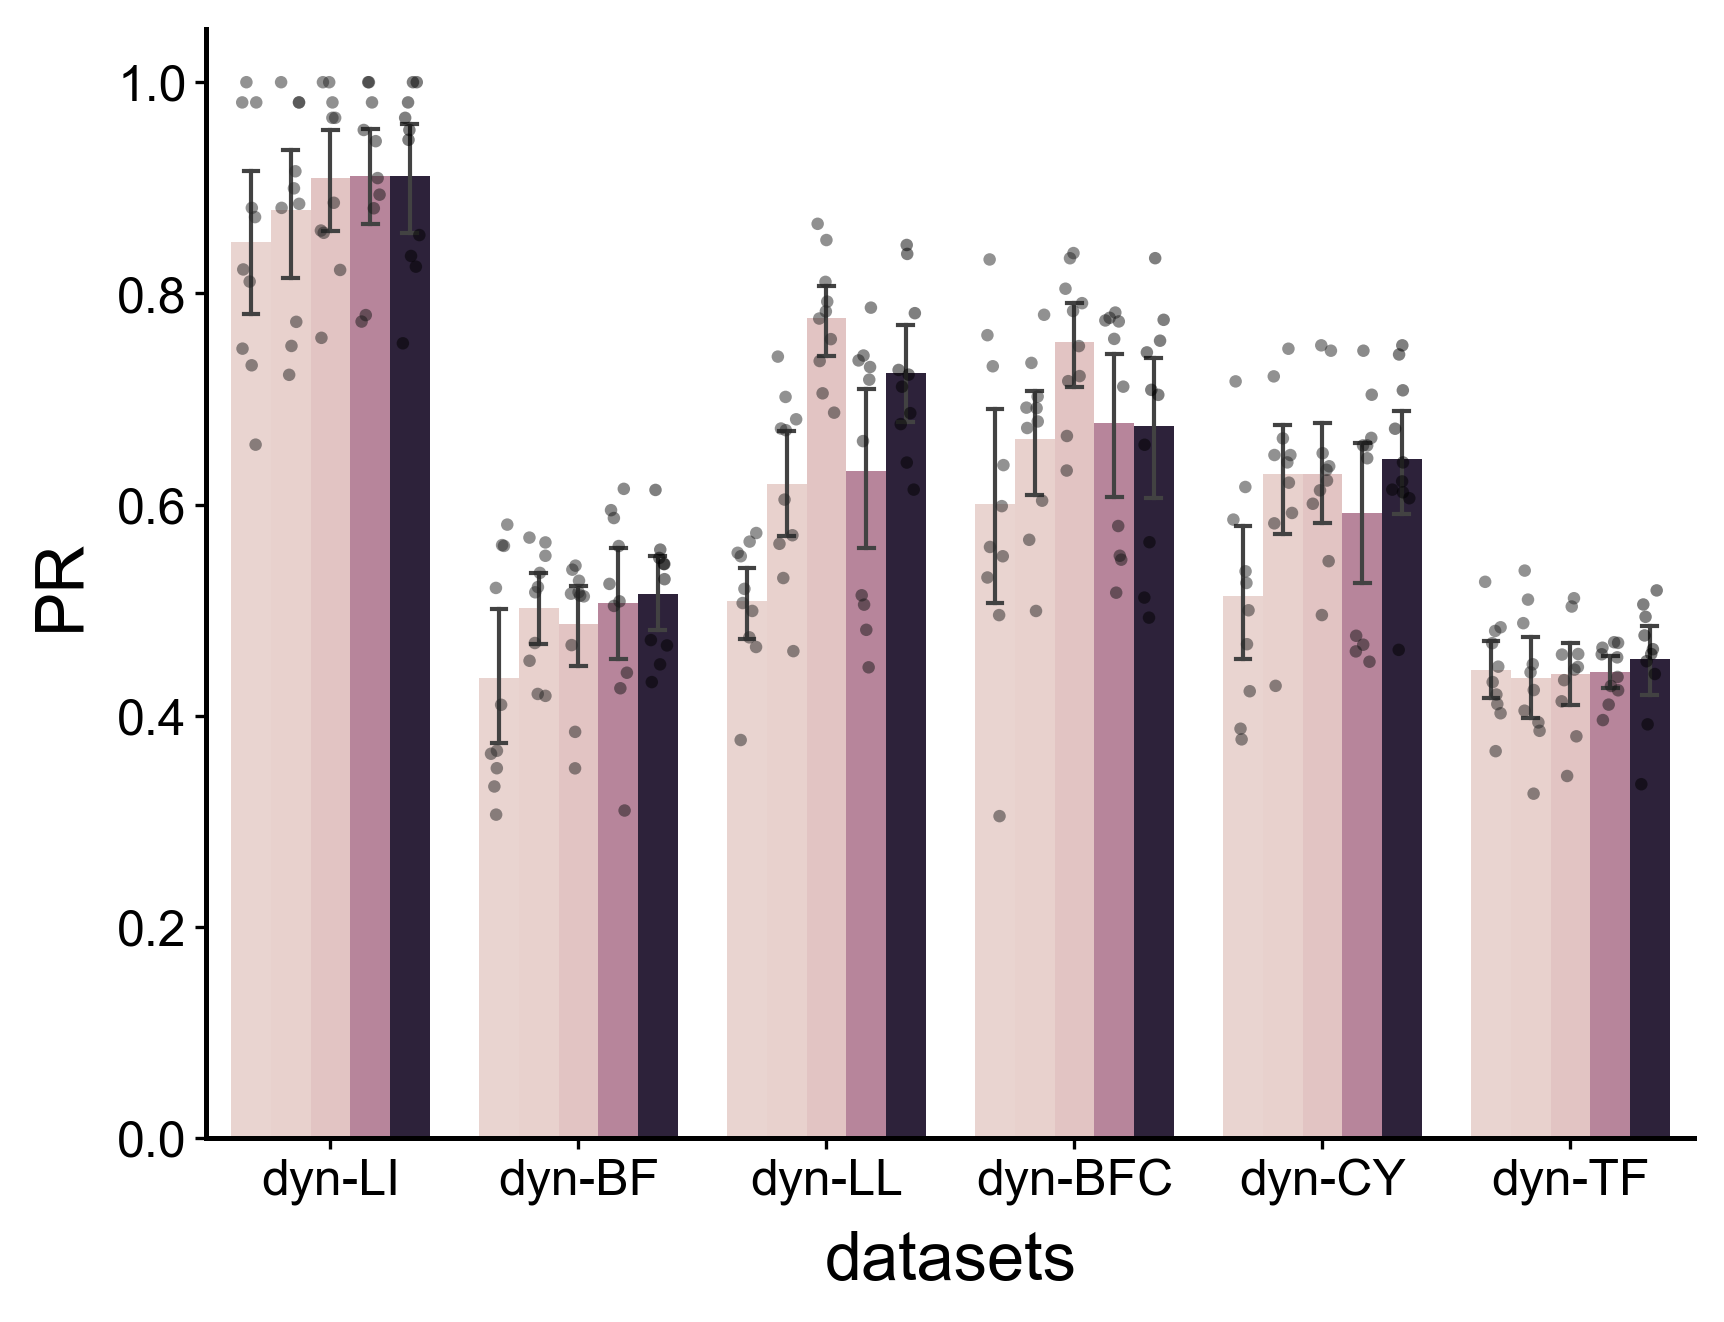

In [6]:
plt.figure(figsize=(6.4, 4.8), dpi=300)


ax = sns.barplot(
    benchmarks, hue='number of cell', y='PR', x='datasets',
    legend=False, 
    capsize=.3,
    err_kws={"linewidth": 1.},
    
    
    
)

sns.stripplot(
    benchmarks, hue='number of cell', y='PR', x='datasets',
    legend=False, 
    dodge=True,  
    jitter=0.2,  
    color="black", alpha=.5,
    ax=ax,
    size=3,

)
plt.show()

In [7]:
random_PR = []
for i in range(len(names)):
    name = 'dyn-' + names[i]
    
    data_dir = '../pygot_data/01_velocity/simulation/inputs/Synthetic/{}/'.format(name) 
    datasets = [d for d in os.listdir(data_dir ) if os.path.isdir(os.path.join(data_dir , d))]
    adata, ref_network, pool = experiment(os.path.join(data_dir, datasets[i]), split_k=5)
    n = len(np.unique(ref_network.Gene1.tolist() + ref_network.Gene2.tolist())) 
    random_PR.append(len(ref_network) / (n * n))

In [8]:
matrix = benchmarks.groupby('method').apply(lambda x: x.groupby('datasets').apply(lambda x: x['PR'].median()))
matrix = matrix[['dyn-LI', 'dyn-BF', 'dyn-LL', 'dyn-BFC', 'dyn-CY', 'dyn-TF']]
matrix = matrix / random_PR
matrix.columns = matrix.columns.to_series().apply(lambda x: x.split('-')[1])

In [9]:
pre_benchmark_results = pd.read_csv('../pygot_data/01_velocity/simulation/Synthetic_beeline_results.csv', index_col=0, skiprows=1)
pre_benchmark_results = pre_benchmark_results[pre_benchmark_results.columns[:6]]


In [10]:
benchmark_results_syn = pd.concat([matrix, pre_benchmark_results])

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5]),
 [Text(0, 0.5, 'GOT'),
  Text(0, 1.5, 'SINCERITIES'),
  Text(0, 2.5, 'SCRIBE'),
  Text(0, 3.5, 'SINGE'),
  Text(0, 4.5, 'PPCOR'),
  Text(0, 5.5, 'PIDC'),
  Text(0, 6.5, 'GENIE3'),
  Text(0, 7.5, 'LEAP'),
  Text(0, 8.5, 'GRNBOOST2'),
  Text(0, 9.5, 'GRISLI'),
  Text(0, 10.5, 'GRNVBEM'),
  Text(0, 11.5, 'SCNS'),
  Text(0, 12.5, 'SCODE')])

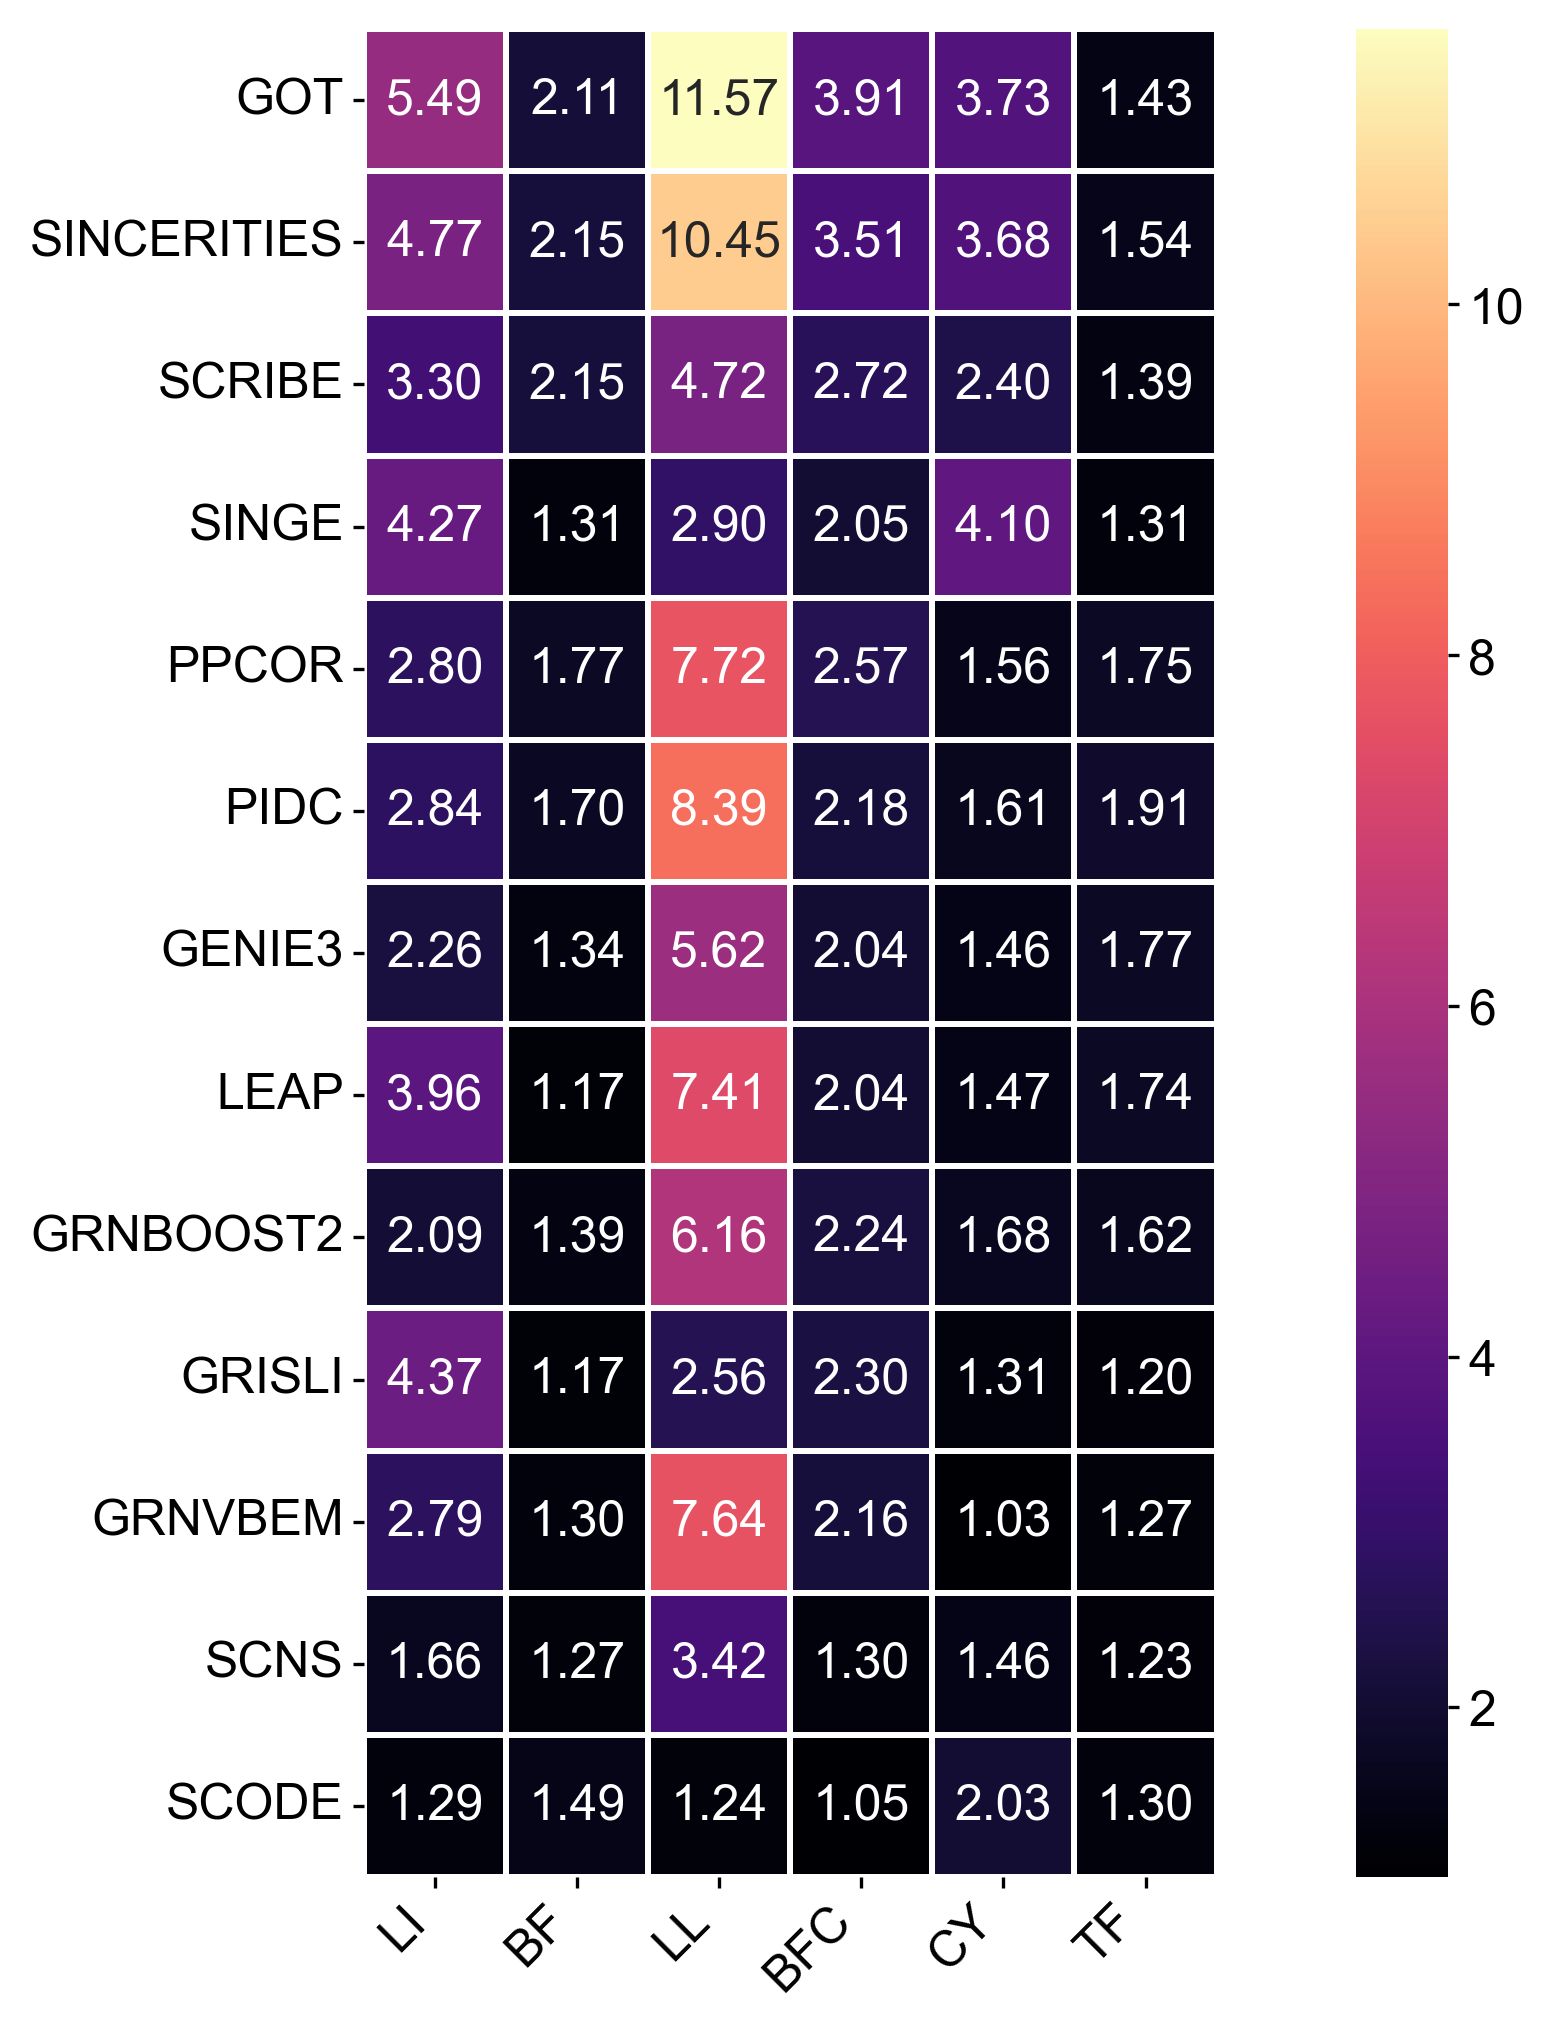

In [11]:
fig, ax = plt.subplots(1,1,figsize=(12, 8), dpi=300)
sns.heatmap(benchmark_results_syn, cmap="magma", square=True, linecolor='white', linewidths=1, ax=ax, annot=True,annot_kws={'fontsize':12}, fmt=".2f")
plt.xlabel("", fontsize=14)  
plt.ylabel("", fontsize=14) 

plt.xticks(rotation=45, ha='right', fontsize=12, color='black') 
plt.yticks(fontsize=12, color='black') 


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5]),
 [Text(0, 0.5, 'GOT'),
  Text(0, 1.5, 'SINCERITIES'),
  Text(0, 2.5, 'SCRIBE'),
  Text(0, 3.5, 'SINGE'),
  Text(0, 4.5, 'PPCOR'),
  Text(0, 5.5, 'PIDC'),
  Text(0, 6.5, 'GENIE3'),
  Text(0, 7.5, 'LEAP'),
  Text(0, 8.5, 'GRNBOOST2'),
  Text(0, 9.5, 'GRISLI'),
  Text(0, 10.5, 'GRNVBEM'),
  Text(0, 11.5, 'SCNS'),
  Text(0, 12.5, 'SCODE')])

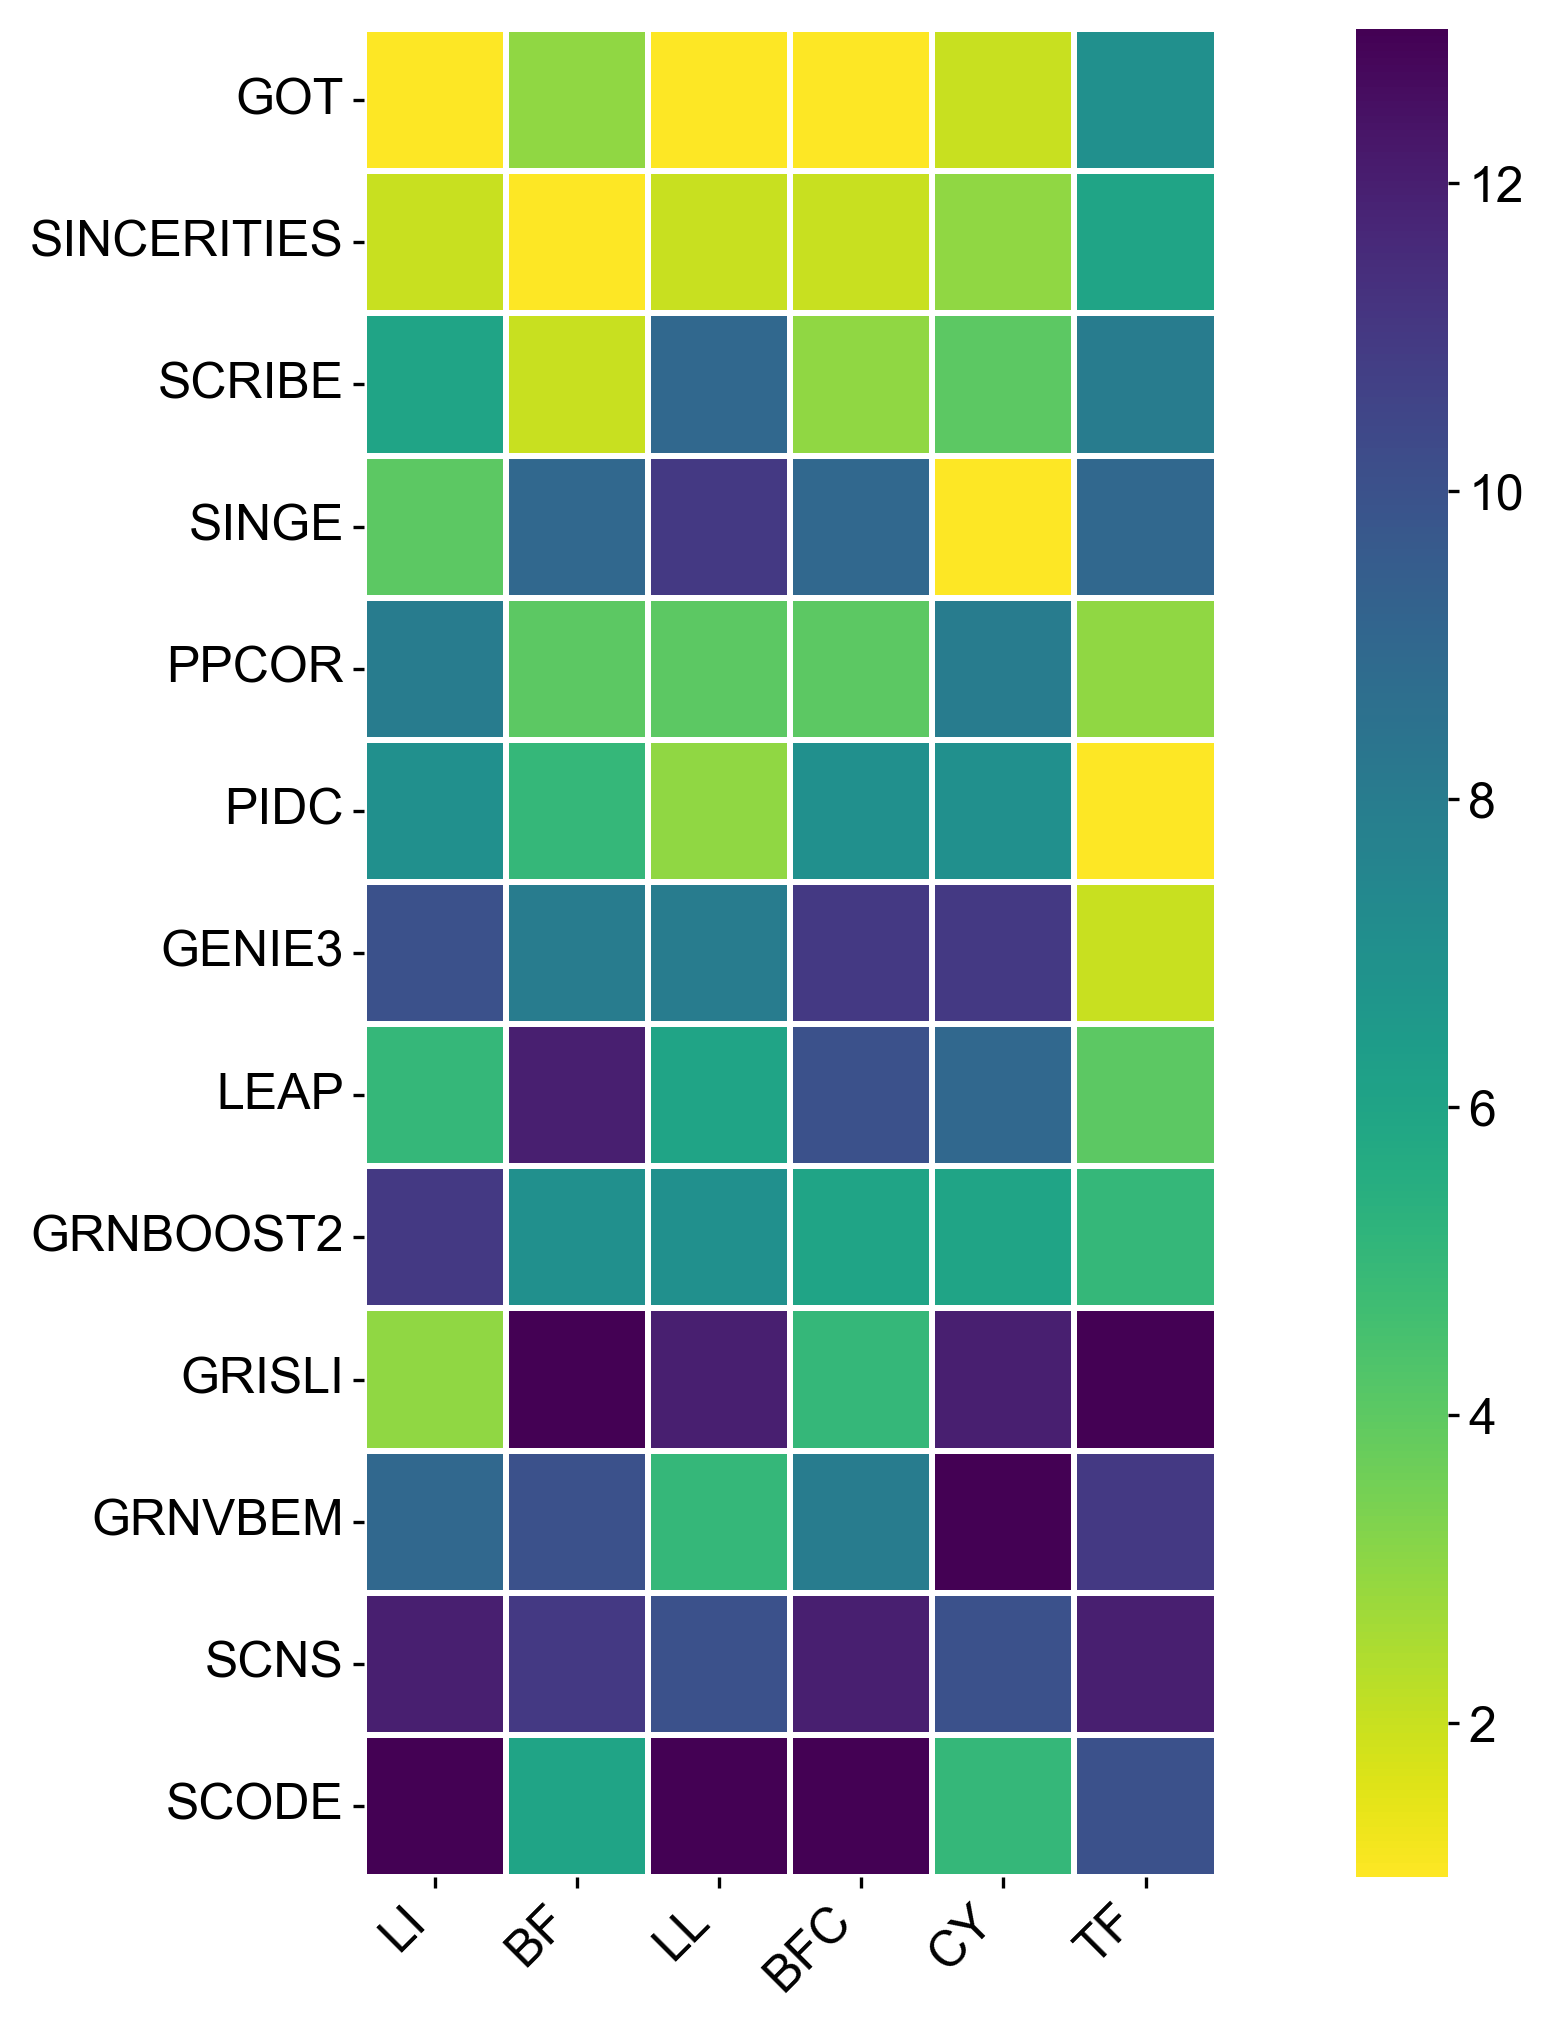

In [12]:
rank_df_syn = benchmark_results_syn.rank(ascending=False, axis=0, method='min')  

fig, ax = plt.subplots(1,1,figsize=(12, 8), dpi=300)
sns.heatmap(rank_df_syn, cmap="viridis_r", square=True, linecolor='white', linewidths=1, ax=ax, annot=False,annot_kws={'fontsize':12}, fmt=".2f")
plt.xlabel("", fontsize=14) 
plt.ylabel("", fontsize=14)  

plt.xticks(rotation=45, ha='right', fontsize=12, color='black')  
plt.yticks(fontsize=12, color='black') 


## Curated

In [13]:
time_key = 'Day'
embedding_key = 'X_latent'
cell_type_key = 'cluster'
names = ['GSD',  'HSC', 'mCAD']
days = [6, 6, 6]
days = [6, 6, 6]

In [ ]:
for i in range(3):
    name = names[i]
    split_k = days[i]
    print(name)
    data_dir = '../pygot_data/01_velocity/simulation/inputs/Curated/{}/'.format(name) 
    datasets = [d for d in os.listdir(data_dir ) if os.path.isdir(os.path.join(data_dir , d))]
    model_save_dir = './benchmark_model/GOT/04_grn/'+name

    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)
    for dataset in datasets:
        print()
        print('**************',dataset,'****************')
        adata, ref_network, _ = experiment('../pygot_data/01_velocity/simulation/inputs//Curated/'+name+'/'+datasets[0] , split_k=6)
        cell_num = int(dataset.split('-')[-2])
        gs_vae = pygot.pp.GS_VAE(device=device)
        gs_vae.register_model(adata=adata, latent_dim=2)

        adata.obsm['X_latent'] = gs_vae.fit_transform(adata, n_epoch=100)
        try:
            model, _ = pygot.tl.traj.fit_velocity_model(adata, time_key=time_key, embedding_key='X_latent', v_centric_iter_n=0, 
                                       device=device)
        except:
            model, _ = pygot.tl.traj.fit_velocity_model(adata, time_key=time_key, embedding_key='X_latent', v_centric_iter_n=0,
                                       device=device)

        adata.layers['velocity'] = pygot.tl.traj.velocity(adata, model.func, time_key=time_key, embedding_key='X_latent', dr_mode='nonlinear', inverse_transform=gs_vae.inverse_transform)
        torch.save(gs_vae, model_save_dir+'/'+dataset+'_vae.pkl')
        torch.save(model, model_save_dir+'/'+dataset+'.pkl')
        sc.write(model_save_dir+'/'+dataset+'.h5ad', adata)

        grn_fitter = pygot.tl.analysis.GRN()
        grn = grn_fitter.fit(adata, TF_constrain=False,  n_epoch=5000, lr=0.01, l1_penalty = 0.005, init_beta=1.0, min_beta=1.,non_negative=False )       
        print(pygot.evalute.compute_pr(ref_network, grn.ranked_edges))
        
        grn.ranked_edges.to_csv(os.path.join(model_save_dir, dataset+'latent_rankedEdges.csv'), sep='\t')
        path = os.path.join('../pygot_data/01_velocity/simulation/ouputs/Curated', name,  dataset, 'GOT')
        os.makedirs(path, exist_ok=True)
        
        grn.ranked_edges.to_csv(os.path.join(path, 'rankedEdges.csv'), sep='\t')
        


GSD

************** GSD-2000-3 ****************
To use VAE, run as following:
     1. gs_vae.register_model
     2. gs_vae.fit / gs_vae.fit_transform
To use GS-VAE, run as following:
     1. gs_vae.precompute_gs
     2. gs_vae.process_gs
     3. gs_vae.register_model
     4. gs_vae.fit / gs_vae.fit_transform


loss :156.1221: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.12it/s]


loading saved shortest path profile
[Errno 2] No such file or directory: '/_0to1.pkl'
Error in loading shortest path file
calcu shortest path between 0 to 1


100%|███████████████████████████████████████████████████████████████████████████████████████| 341/341 [00:00<00:00, 3546.35it/s]


calcu shortest path between 1 to 2


100%|███████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3384.56it/s]


calcu shortest path between 2 to 3


100%|███████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 3930.70it/s]


calcu shortest path between 3 to 4


100%|███████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 5083.20it/s]


calcu shortest path between 4 to 5


100%|███████████████████████████████████████████████████████████████████████████████████████| 345/345 [00:00<00:00, 4782.48it/s]
0it [00:00, ?it/s]
loss :9.3574  best :9.0781: 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:18<00:00, 25.63it/s]


TF number: 19, Index(['AMH', 'CBX2', 'CTNNB1', 'DHH', 'DKK1', 'DMRT1', 'FGF9', 'FOXL2',
       'GATA4', 'NR0B1', 'NR5A1', 'PGD2', 'RSPO1', 'SOX9', 'SRY', 'UGR',
       'WNT4', 'WT1mKTS', 'WT1pKTS'],
      dtype='object')
scale velocity with factor : 3.286382270700134
l1_penalty: 0.005 min_beta: 1.0


Epoch [5000/5000], Train Loss: 1.4682, Val Loss: 1.4784: 100%|█████████████████████████████| 5000/5000 [00:10<00:00, 458.71it/s]


0.4501026604445367

************** GSD-2000-2-50 ****************
To use VAE, run as following:
     1. gs_vae.register_model
     2. gs_vae.fit / gs_vae.fit_transform
To use GS-VAE, run as following:
     1. gs_vae.precompute_gs
     2. gs_vae.process_gs
     3. gs_vae.register_model
     4. gs_vae.fit / gs_vae.fit_transform


loss :11.4317  best :11.4317: 100%|█████████████████████████████████████████████████████████| 2000/2000 [01:17<00:00, 25.80it/s]


TF number: 19, Index(['AMH', 'CBX2', 'CTNNB1', 'DHH', 'DKK1', 'DMRT1', 'FGF9', 'FOXL2',
       'GATA4', 'NR0B1', 'NR5A1', 'PGD2', 'RSPO1', 'SOX9', 'SRY', 'UGR',
       'WNT4', 'WT1mKTS', 'WT1pKTS'],
      dtype='object')
scale velocity with factor : 4.190782569689081
l1_penalty: 0.005 min_beta: 1.0


Epoch [5000/5000], Train Loss: 1.3516, Val Loss: 1.4172: 100%|█████████████████████████████| 5000/5000 [00:11<00:00, 451.46it/s]


0.37662255905996855

************** GSD-2000-9-70 ****************
To use VAE, run as following:
     1. gs_vae.register_model
     2. gs_vae.fit / gs_vae.fit_transform
To use GS-VAE, run as following:
     1. gs_vae.precompute_gs
     2. gs_vae.process_gs
     3. gs_vae.register_model
     4. gs_vae.fit / gs_vae.fit_transform


loss :7.3942  best :7.3942: 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:18<00:00, 25.36it/s]


TF number: 19, Index(['AMH', 'CBX2', 'CTNNB1', 'DHH', 'DKK1', 'DMRT1', 'FGF9', 'FOXL2',
       'GATA4', 'NR0B1', 'NR5A1', 'PGD2', 'RSPO1', 'SOX9', 'SRY', 'UGR',
       'WNT4', 'WT1mKTS', 'WT1pKTS'],
      dtype='object')
scale velocity with factor : 3.6320976100705566
l1_penalty: 0.005 min_beta: 1.0


Epoch [5000/5000], Train Loss: 1.7281, Val Loss: 1.6999: 100%|█████████████████████████████| 5000/5000 [00:10<00:00, 465.46it/s]


0.4031625297364607

************** GSD-2000-6-50 ****************
To use VAE, run as following:
     1. gs_vae.register_model
     2. gs_vae.fit / gs_vae.fit_transform
To use GS-VAE, run as following:
     1. gs_vae.precompute_gs
     2. gs_vae.process_gs
     3. gs_vae.register_model
     4. gs_vae.fit / gs_vae.fit_transform


Epoch [5000/5000], Train Loss: 1.6368, Val Loss: 1.6848: 100%|█████████████████████████████| 5000/5000 [00:11<00:00, 453.29it/s]


0.415203810163095

************** GSD-2000-7-70 ****************
To use VAE, run as following:
     1. gs_vae.register_model
     2. gs_vae.fit / gs_vae.fit_transform
To use GS-VAE, run as following:
     1. gs_vae.precompute_gs
     2. gs_vae.process_gs
     3. gs_vae.register_model
     4. gs_vae.fit / gs_vae.fit_transform


loss :153.9520: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.86it/s]


loading saved shortest path profile
[Errno 2] No such file or directory: '/_0to1.pkl'
Error in loading shortest path file
calcu shortest path between 0 to 1


100%|███████████████████████████████████████████████████████████████████████████████████████| 341/341 [00:00<00:00, 3520.53it/s]


calcu shortest path between 1 to 2


100%|███████████████████████████████████████████████████████████████████████████████████████| 350/350 [00:00<00:00, 3379.02it/s]


calcu shortest path between 2 to 3


100%|███████████████████████████████████████████████████████████████████████████████████████| 321/321 [00:00<00:00, 3952.62it/s]


calcu shortest path between 3 to 4


100%|███████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 5118.71it/s]


calcu shortest path between 4 to 5


100%|███████████████████████████████████████████████████████████████████████████████████████| 345/345 [00:00<00:00, 4803.42it/s]
0it [00:00, ?it/s]
loss :11.1960  best :10.6285: 100%|█████████████████████████████████████████████████████████| 2000/2000 [01:18<00:00, 25.32it/s]


TF number: 19, Index(['AMH', 'CBX2', 'CTNNB1', 'DHH', 'DKK1', 'DMRT1', 'FGF9', 'FOXL2',
       'GATA4', 'NR0B1', 'NR5A1', 'PGD2', 'RSPO1', 'SOX9', 'SRY', 'UGR',
       'WNT4', 'WT1mKTS', 'WT1pKTS'],
      dtype='object')
scale velocity with factor : 4.0747861076955685
l1_penalty: 0.005 min_beta: 1.0


loss :10.5989  best :10.5989: 100%|█████████████████████████████████████████████████████████| 2000/2000 [01:19<00:00, 25.03it/s]


TF number: 19, Index(['AMH', 'CBX2', 'CTNNB1', 'DHH', 'DKK1', 'DMRT1', 'FGF9', 'FOXL2',
       'GATA4', 'NR0B1', 'NR5A1', 'PGD2', 'RSPO1', 'SOX9', 'SRY', 'UGR',
       'WNT4', 'WT1mKTS', 'WT1pKTS'],
      dtype='object')
scale velocity with factor : 3.7975031022591685
l1_penalty: 0.005 min_beta: 1.0


loss :11.1293  best :10.8582: 100%|█████████████████████████████████████████████████████████| 2000/2000 [01:18<00:00, 25.57it/s]


TF number: 19, Index(['AMH', 'CBX2', 'CTNNB1', 'DHH', 'DKK1', 'DMRT1', 'FGF9', 'FOXL2',
       'GATA4', 'NR0B1', 'NR5A1', 'PGD2', 'RSPO1', 'SOX9', 'SRY', 'UGR',
       'WNT4', 'WT1mKTS', 'WT1pKTS'],
      dtype='object')
scale velocity with factor : 4.074479453877175
l1_penalty: 0.005 min_beta: 1.0


loss :10.1335  best :9.9716: 100%|██████████████████████████████████████████████████████████| 2000/2000 [01:16<00:00, 26.07it/s]


TF number: 19, Index(['AMH', 'CBX2', 'CTNNB1', 'DHH', 'DKK1', 'DMRT1', 'FGF9', 'FOXL2',
       'GATA4', 'NR0B1', 'NR5A1', 'PGD2', 'RSPO1', 'SOX9', 'SRY', 'UGR',
       'WNT4', 'WT1mKTS', 'WT1pKTS'],
      dtype='object')
scale velocity with factor : 3.989017232551067
l1_penalty: 0.005 min_beta: 1.0


loss :8.4701  best :8.4701: 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:19<00:00, 25.26it/s]


TF number: 19, Index(['AMH', 'CBX2', 'CTNNB1', 'DHH', 'DKK1', 'DMRT1', 'FGF9', 'FOXL2',
       'GATA4', 'NR0B1', 'NR5A1', 'PGD2', 'RSPO1', 'SOX9', 'SRY', 'UGR',
       'WNT4', 'WT1mKTS', 'WT1pKTS'],
      dtype='object')
scale velocity with factor : 3.804666786971578
l1_penalty: 0.005 min_beta: 1.0


loss :11.1169  best :11.1169: 100%|█████████████████████████████████████████████████████████| 2000/2000 [01:19<00:00, 25.21it/s]


TF number: 19, Index(['AMH', 'CBX2', 'CTNNB1', 'DHH', 'DKK1', 'DMRT1', 'FGF9', 'FOXL2',
       'GATA4', 'NR0B1', 'NR5A1', 'PGD2', 'RSPO1', 'SOX9', 'SRY', 'UGR',
       'WNT4', 'WT1mKTS', 'WT1pKTS'],
      dtype='object')
scale velocity with factor : 4.412325595125964
l1_penalty: 0.005 min_beta: 1.0


loss :90.8044: 100%|██████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.66it/s]


loading saved shortest path profile
[Errno 2] No such file or directory: '/_0to1.pkl'
Error in loading shortest path file
calcu shortest path between 0 to 1


100%|███████████████████████████████████████████████████████████████████████████████████████| 337/337 [00:00<00:00, 3489.49it/s]


calcu shortest path between 1 to 2


100%|███████████████████████████████████████████████████████████████████████████████████████| 325/325 [00:00<00:00, 4061.57it/s]


calcu shortest path between 2 to 3


100%|███████████████████████████████████████████████████████████████████████████████████████| 314/314 [00:00<00:00, 6974.96it/s]


calcu shortest path between 3 to 4


100%|███████████████████████████████████████████████████████████████████████████████████████| 333/333 [00:00<00:00, 7076.21it/s]


calcu shortest path between 4 to 5


100%|███████████████████████████████████████████████████████████████████████████████████████| 329/329 [00:00<00:00, 8633.76it/s]
0it [00:00, ?it/s]
loss :7.0523  best :7.0346: 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:10<00:00, 28.18it/s]


TF number: 11, Index(['Cebpa', 'EgrNab', 'Eklf', 'Fli1', 'Fog1', 'Gata1', 'Gata2', 'Gfi1',
       'Pu1', 'Scl', 'cJun'],
      dtype='object')
scale velocity with factor : 14.440933410613663
l1_penalty: 0.005 min_beta: 1.0


loss :8.2115  best :7.9501: 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:10<00:00, 28.28it/s]


TF number: 11, Index(['Cebpa', 'EgrNab', 'Eklf', 'Fli1', 'Fog1', 'Gata1', 'Gata2', 'Gfi1',
       'Pu1', 'Scl', 'cJun'],
      dtype='object')
scale velocity with factor : 13.274422329914566
l1_penalty: 0.005 min_beta: 1.0


loss :6.4846  best :6.4846: 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:12<00:00, 27.75it/s]


TF number: 11, Index(['Cebpa', 'EgrNab', 'Eklf', 'Fli1', 'Fog1', 'Gata1', 'Gata2', 'Gfi1',
       'Pu1', 'Scl', 'cJun'],
      dtype='object')
scale velocity with factor : 10.701003135625424
l1_penalty: 0.005 min_beta: 1.0


loss :108.0144: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:08<00:00, 11.46it/s]


loading saved shortest path profile
[Errno 2] No such file or directory: '/_0to1.pkl'
Error in loading shortest path file
calcu shortest path between 0 to 1


100%|███████████████████████████████████████████████████████████████████████████████████████| 337/337 [00:00<00:00, 3591.93it/s]


calcu shortest path between 1 to 2


100%|███████████████████████████████████████████████████████████████████████████████████████| 325/325 [00:00<00:00, 4283.08it/s]


calcu shortest path between 2 to 3


100%|███████████████████████████████████████████████████████████████████████████████████████| 314/314 [00:00<00:00, 8013.75it/s]


calcu shortest path between 3 to 4


100%|███████████████████████████████████████████████████████████████████████████████████████| 333/333 [00:00<00:00, 8333.55it/s]


calcu shortest path between 4 to 5


100%|███████████████████████████████████████████████████████████████████████████████████████| 329/329 [00:00<00:00, 8576.51it/s]
0it [00:00, ?it/s]
loss :7.0538  best :7.0538: 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:13<00:00, 27.29it/s]


TF number: 11, Index(['Cebpa', 'EgrNab', 'Eklf', 'Fli1', 'Fog1', 'Gata1', 'Gata2', 'Gfi1',
       'Pu1', 'Scl', 'cJun'],
      dtype='object')
scale velocity with factor : 15.188179082582872
l1_penalty: 0.005 min_beta: 1.0


loss :6.7537  best :6.7537: 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:13<00:00, 27.30it/s]


TF number: 11, Index(['Cebpa', 'EgrNab', 'Eklf', 'Fli1', 'Fog1', 'Gata1', 'Gata2', 'Gfi1',
       'Pu1', 'Scl', 'cJun'],
      dtype='object')
scale velocity with factor : 10.961894811856675
l1_penalty: 0.005 min_beta: 1.0


loss :7.0288  best :7.0288: 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:13<00:00, 27.20it/s]


TF number: 11, Index(['Cebpa', 'EgrNab', 'Eklf', 'Fli1', 'Fog1', 'Gata1', 'Gata2', 'Gfi1',
       'Pu1', 'Scl', 'cJun'],
      dtype='object')
scale velocity with factor : 12.650292347055931
l1_penalty: 0.005 min_beta: 1.0


loss :7.3010  best :7.3010: 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:13<00:00, 27.32it/s]


TF number: 11, Index(['Cebpa', 'EgrNab', 'Eklf', 'Fli1', 'Fog1', 'Gata1', 'Gata2', 'Gfi1',
       'Pu1', 'Scl', 'cJun'],
      dtype='object')
scale velocity with factor : 14.723020541952355
l1_penalty: 0.005 min_beta: 1.0


Epoch [5000/5000], Train Loss: 3.5344, Val Loss: 3.9718: 100%|█████████████████████████████| 5000/5000 [00:07<00:00, 671.71it/s]


0.24276827834159248

************** HSC-2000-5-50 ****************
To use VAE, run as following:
     1. gs_vae.register_model
     2. gs_vae.fit / gs_vae.fit_transform
To use GS-VAE, run as following:
     1. gs_vae.precompute_gs
     2. gs_vae.process_gs
     3. gs_vae.register_model
     4. gs_vae.fit / gs_vae.fit_transform


loss :113.1857: 100%|█████████████████████████████████████████████████████████████████████████| 100/100 [00:07<00:00, 12.82it/s]


loading saved shortest path profile
[Errno 2] No such file or directory: '/_0to1.pkl'
Error in loading shortest path file
calcu shortest path between 0 to 1


100%|███████████████████████████████████████████████████████████████████████████████████████| 337/337 [00:00<00:00, 3600.10it/s]


calcu shortest path between 1 to 2


100%|███████████████████████████████████████████████████████████████████████████████████████| 325/325 [00:00<00:00, 4199.72it/s]


calcu shortest path between 2 to 3


100%|███████████████████████████████████████████████████████████████████████████████████████| 314/314 [00:00<00:00, 8463.98it/s]


calcu shortest path between 3 to 4


100%|███████████████████████████████████████████████████████████████████████████████████████| 333/333 [00:00<00:00, 8923.77it/s]


calcu shortest path between 4 to 5


100%|███████████████████████████████████████████████████████████████████████████████████████| 329/329 [00:00<00:00, 8969.82it/s]
0it [00:00, ?it/s]
loss :6.9581  best :6.9411: 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:13<00:00, 27.29it/s]


TF number: 11, Index(['Cebpa', 'EgrNab', 'Eklf', 'Fli1', 'Fog1', 'Gata1', 'Gata2', 'Gfi1',
       'Pu1', 'Scl', 'cJun'],
      dtype='object')
scale velocity with factor : 13.47285026683129
l1_penalty: 0.005 min_beta: 1.0


loss :7.7668  best :7.5846: 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:13<00:00, 27.17it/s]


TF number: 11, Index(['Cebpa', 'EgrNab', 'Eklf', 'Fli1', 'Fog1', 'Gata1', 'Gata2', 'Gfi1',
       'Pu1', 'Scl', 'cJun'],
      dtype='object')
scale velocity with factor : 14.521902206703874
l1_penalty: 0.005 min_beta: 1.0


loss :3.2869  best :3.1893: 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:15<00:00, 26.65it/s]


TF number: 5, Index(['Coup', 'Emx2', 'Fgf8', 'Pax6', 'Sp8'], dtype='object')
scale velocity with factor : 6.431167463951006
l1_penalty: 0.005 min_beta: 1.0


Epoch [4071/5000], Train Loss: 3.2013, Val Loss: 3.0349:  81%|███████████████████████▌     | 4071/5000 [00:08<00:01, 479.03it/s]


Early stopping at epoch 4072. Best validation loss: 3.03489
0.73556059589639

************** mCAD-2000-2-50 ****************
To use VAE, run as following:
     1. gs_vae.register_model
     2. gs_vae.fit / gs_vae.fit_transform
To use GS-VAE, run as following:
     1. gs_vae.precompute_gs
     2. gs_vae.process_gs
     3. gs_vae.register_model
     4. gs_vae.fit / gs_vae.fit_transform


loss :3.3930  best :3.3930: 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:16<00:00, 26.30it/s]


TF number: 5, Index(['Coup', 'Emx2', 'Fgf8', 'Pax6', 'Sp8'], dtype='object')
scale velocity with factor : 6.538020503511685
l1_penalty: 0.005 min_beta: 1.0


loss :3.2221  best :3.1157: 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:15<00:00, 26.33it/s]


TF number: 5, Index(['Coup', 'Emx2', 'Fgf8', 'Pax6', 'Sp8'], dtype='object')
scale velocity with factor : 6.951806360574838
l1_penalty: 0.005 min_beta: 1.0


loss :3.1026  best :3.1026: 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:16<00:00, 26.01it/s]


TF number: 5, Index(['Coup', 'Emx2', 'Fgf8', 'Pax6', 'Sp8'], dtype='object')
scale velocity with factor : 6.795915032001665
l1_penalty: 0.005 min_beta: 1.0


loss :3.2848  best :3.2848: 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:16<00:00, 26.19it/s]


TF number: 5, Index(['Coup', 'Emx2', 'Fgf8', 'Pax6', 'Sp8'], dtype='object')
scale velocity with factor : 6.974091145643596
l1_penalty: 0.005 min_beta: 1.0


loss :2.8061  best :2.8061: 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:16<00:00, 26.09it/s]


TF number: 5, Index(['Coup', 'Emx2', 'Fgf8', 'Pax6', 'Sp8'], dtype='object')
scale velocity with factor : 5.735014798701972
l1_penalty: 0.005 min_beta: 1.0


loss :3.3638  best :3.2630: 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:16<00:00, 26.11it/s]


TF number: 5, Index(['Coup', 'Emx2', 'Fgf8', 'Pax6', 'Sp8'], dtype='object')
scale velocity with factor : 6.787511570589611
l1_penalty: 0.005 min_beta: 1.0


Epoch [5000/5000], Train Loss: 2.6070, Val Loss: 3.0275: 100%|█████████████████████████████| 5000/5000 [00:09<00:00, 515.08it/s]


0.7902797101683741

************** mCAD-2000-2 ****************
To use VAE, run as following:
     1. gs_vae.register_model
     2. gs_vae.fit / gs_vae.fit_transform
To use GS-VAE, run as following:
     1. gs_vae.precompute_gs
     2. gs_vae.process_gs
     3. gs_vae.register_model
     4. gs_vae.fit / gs_vae.fit_transform


loss :3.5907  best :3.5053: 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:15<00:00, 26.39it/s]


TF number: 5, Index(['Coup', 'Emx2', 'Fgf8', 'Pax6', 'Sp8'], dtype='object')
scale velocity with factor : 5.667705797895492
l1_penalty: 0.005 min_beta: 1.0


loss :3.2346  best :3.1482: 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:15<00:00, 26.32it/s]


TF number: 5, Index(['Coup', 'Emx2', 'Fgf8', 'Pax6', 'Sp8'], dtype='object')
scale velocity with factor : 6.458042041708361
l1_penalty: 0.005 min_beta: 1.0


loss :3.3743  best :3.3743: 100%|███████████████████████████████████████████████████████████| 2000/2000 [01:13<00:00, 27.29it/s]


TF number: 5, Index(['Coup', 'Emx2', 'Fgf8', 'Pax6', 'Sp8'], dtype='object')
scale velocity with factor : 7.136955086476851
l1_penalty: 0.005 min_beta: 1.0


Epoch [3272/5000], Train Loss: 2.1146, Val Loss: 2.0250:  65%|██████████████████▊          | 3254/5000 [00:07<00:03, 456.52it/s]

In [15]:
benchmarks = []
method='GOT'
for name in names:
    data_dir = '../pygot_data/01_velocity/simulation/outputs/Curated/'+name 
    datasets = [d for d in os.listdir(data_dir ) if os.path.isdir(os.path.join(data_dir , d) ) and d.startswith(name)]
    adata, ref_network, pool = experiment('../pygot_data/01_velocity/simulation/inputs//Curated/'+name+'/'+datasets[0] , split_k=4)
    methods = ['GOT']
    
    benchmark_data_pr = []
    benchmark_data_epr = []
    
    eprs, prs = [], []
    dropout = []
    for dataset in tqdm(datasets):
        
        path = data_dir + '/' + dataset + '/' + method

        dropout.append(int(dataset.split('-')[-1]) if len(dataset.split('-')) == 4 else 0)
        pred_df = pd.read_csv(path+'/rankedEdges.csv', sep='\t')
        epr,_ = pygot.evalute.compute_epr(ref_network, pred_df, len(adata.var), sign=False)
        pr = pygot.evalute.compute_pr(ref_network, pred_df)
        eprs.append(epr)
        prs.append(pr)
    res = pd.DataFrame(np.stack([eprs, dropout]).T, index=datasets, columns=['EPR', 'dropout'])
    res['method'] = method
    benchmark_data_epr.append(res)
    res = pd.DataFrame(np.stack([prs, dropout]).T, index=datasets, columns=['PR', 'dropout'])
    res['method'] = method
    benchmark_data_pr.append(res)
    benchmark_data_pr = pd.concat(benchmark_data_pr)
    benchmark_data_pr['datasets'] = name
    benchmarks.append(benchmark_data_pr)
benchmarks = pd.concat(benchmarks)

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 35.73it/s]


In [16]:
benchmarks

,PR,dropout,method,datasets
GSD-2000-3,0.458453,0.0,GOT,GSD
GSD-2000-2-50,0.417273,50.0,GOT,GSD
GSD-2000-1,0.447022,0.0,GOT,GSD
GSD-2000-3-50,0.442681,50.0,GOT,GSD
GSD-2000-2-70,0.321710,70.0,GOT,GSD
...,...,...,...,...
mCAD-2000-5,0.779279,0.0,GOT,mCAD
mCAD-2000-6,0.750131,0.0,GOT,mCAD
mCAD-2000-3,0.761486,0.0,GOT,mCAD
mCAD-2000-6-70,0.624638,70.0,GOT,mCAD


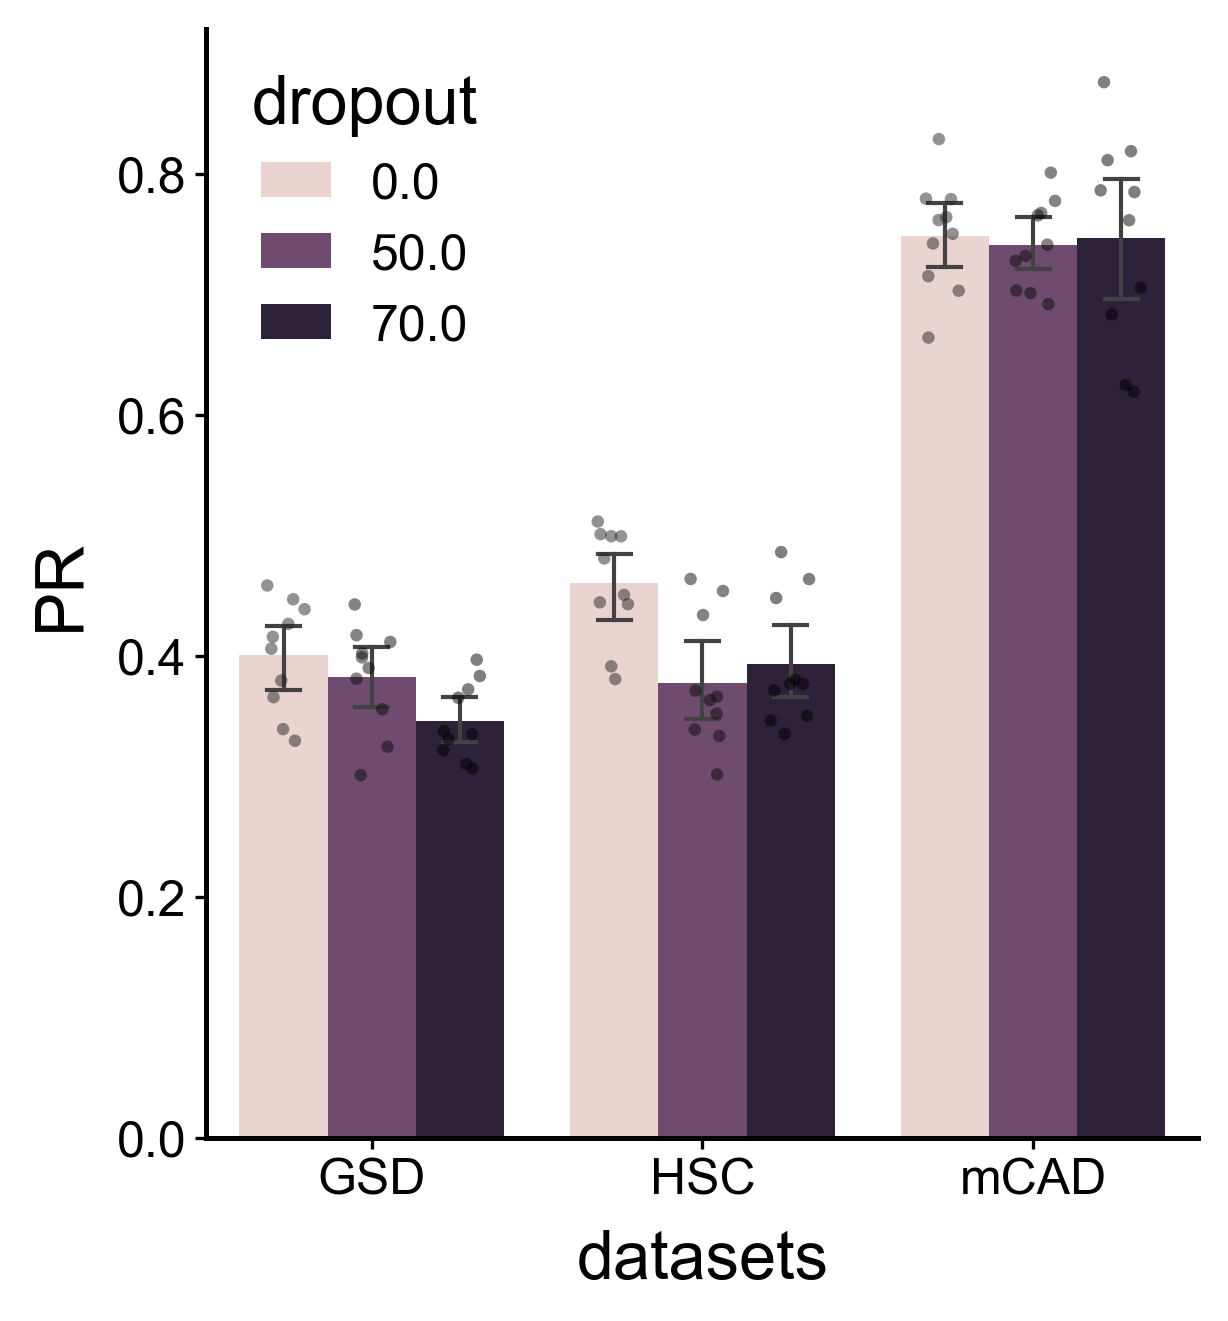

In [17]:
plt.figure(figsize=(6.4* 2 / 3, 4.8), dpi=300)

ax = sns.barplot(
    benchmarks, hue='dropout', y='PR', x='datasets',
    legend=True, 
    capsize=.3,
    hue_order=[70.0, 50.0, 0.0],
    err_kws={"linewidth": 1.},
        
)


sns.stripplot(
    benchmarks, hue='dropout', y='PR', x='datasets',
    legend=False, 
    dodge=True,  
    jitter=0.2, 
    color="black", alpha=.5,
    hue_order=[70.0, 50.0, 0.0],
    ax=ax,
    size=3,

)
plt.show()

In [18]:
random_PR = []
for i in range(len(names)):
    name = names[i]
    
    data_dir = '../pygot_data/01_velocity/simulation/inputs/Curated/{}/'.format(name) 
    datasets = [d for d in os.listdir(data_dir ) if os.path.isdir(os.path.join(data_dir , d))]
    adata, ref_network, pool = experiment(os.path.join(data_dir, datasets[i]), split_k=5)
    n = len(np.unique(ref_network.Gene1.tolist() + ref_network.Gene2.tolist())) 
    random_PR.append(len(ref_network) / (n * n))

In [19]:
matrix = benchmarks.groupby('method').apply(lambda x: x.groupby('datasets').apply(lambda x: x['PR'].median()))
matrix = matrix[names]
matrix = matrix / random_PR


In [20]:
pre_benchmark_results = pd.read_csv('../pygot_data/01_velocity/simulation/Curated_beeline_results.csv', index_col=0, skiprows=1)
pre_benchmark_results = pre_benchmark_results[names]


In [21]:
benchmark_results_curated = pd.concat([matrix, pre_benchmark_results])

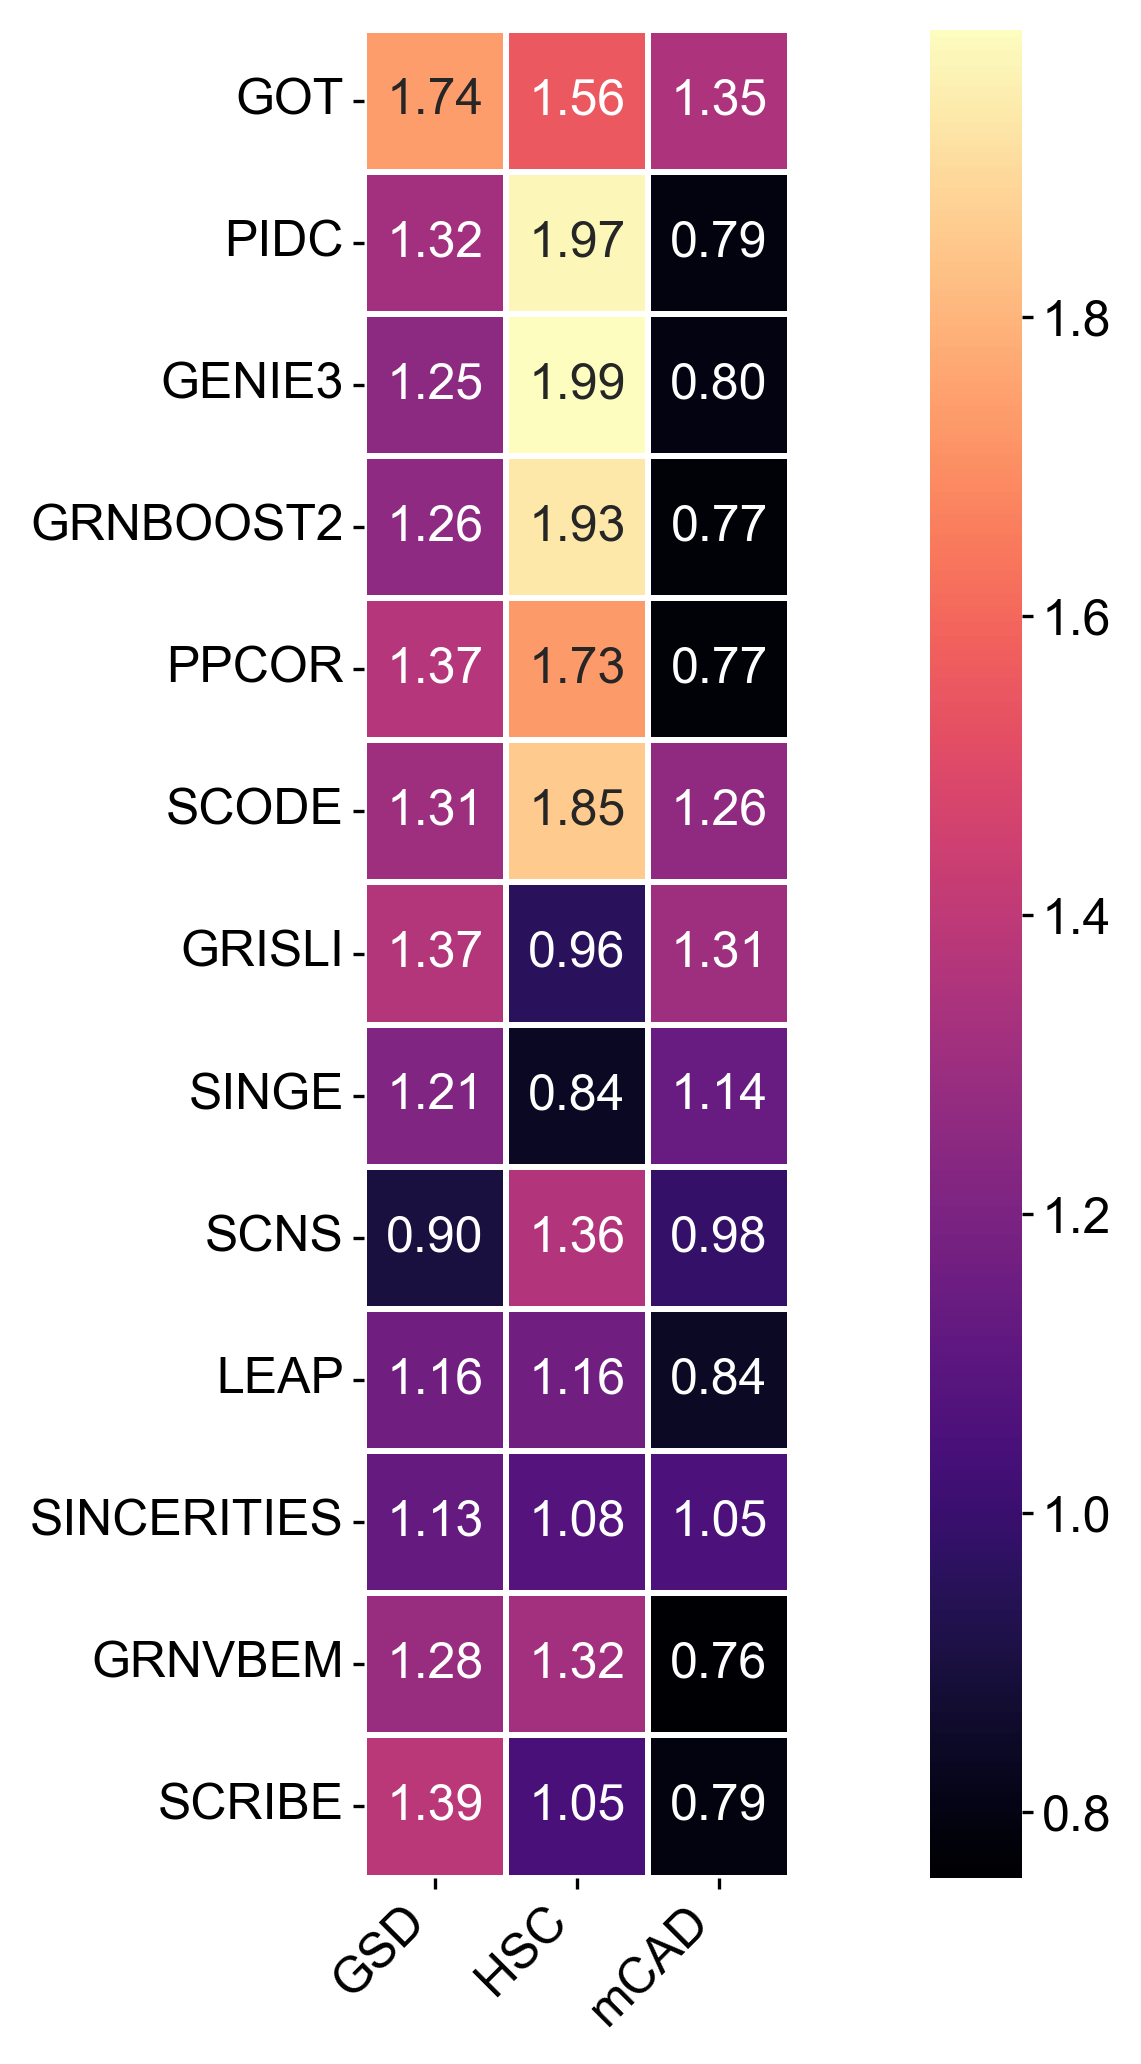

In [22]:
fig, ax = plt.subplots(1,1,figsize=(12, 8), dpi=300)
sns.heatmap(benchmark_results_curated, cmap="magma", square=True, linecolor='white', linewidths=1, ax=ax, annot=True,annot_kws={'fontsize':12}, fmt=".2f")
plt.xlabel("", fontsize=14) 
plt.ylabel("", fontsize=14)

plt.xticks(rotation=45, ha='right', fontsize=12, color='black') 
plt.yticks(fontsize=12, color='black')
plt.show()

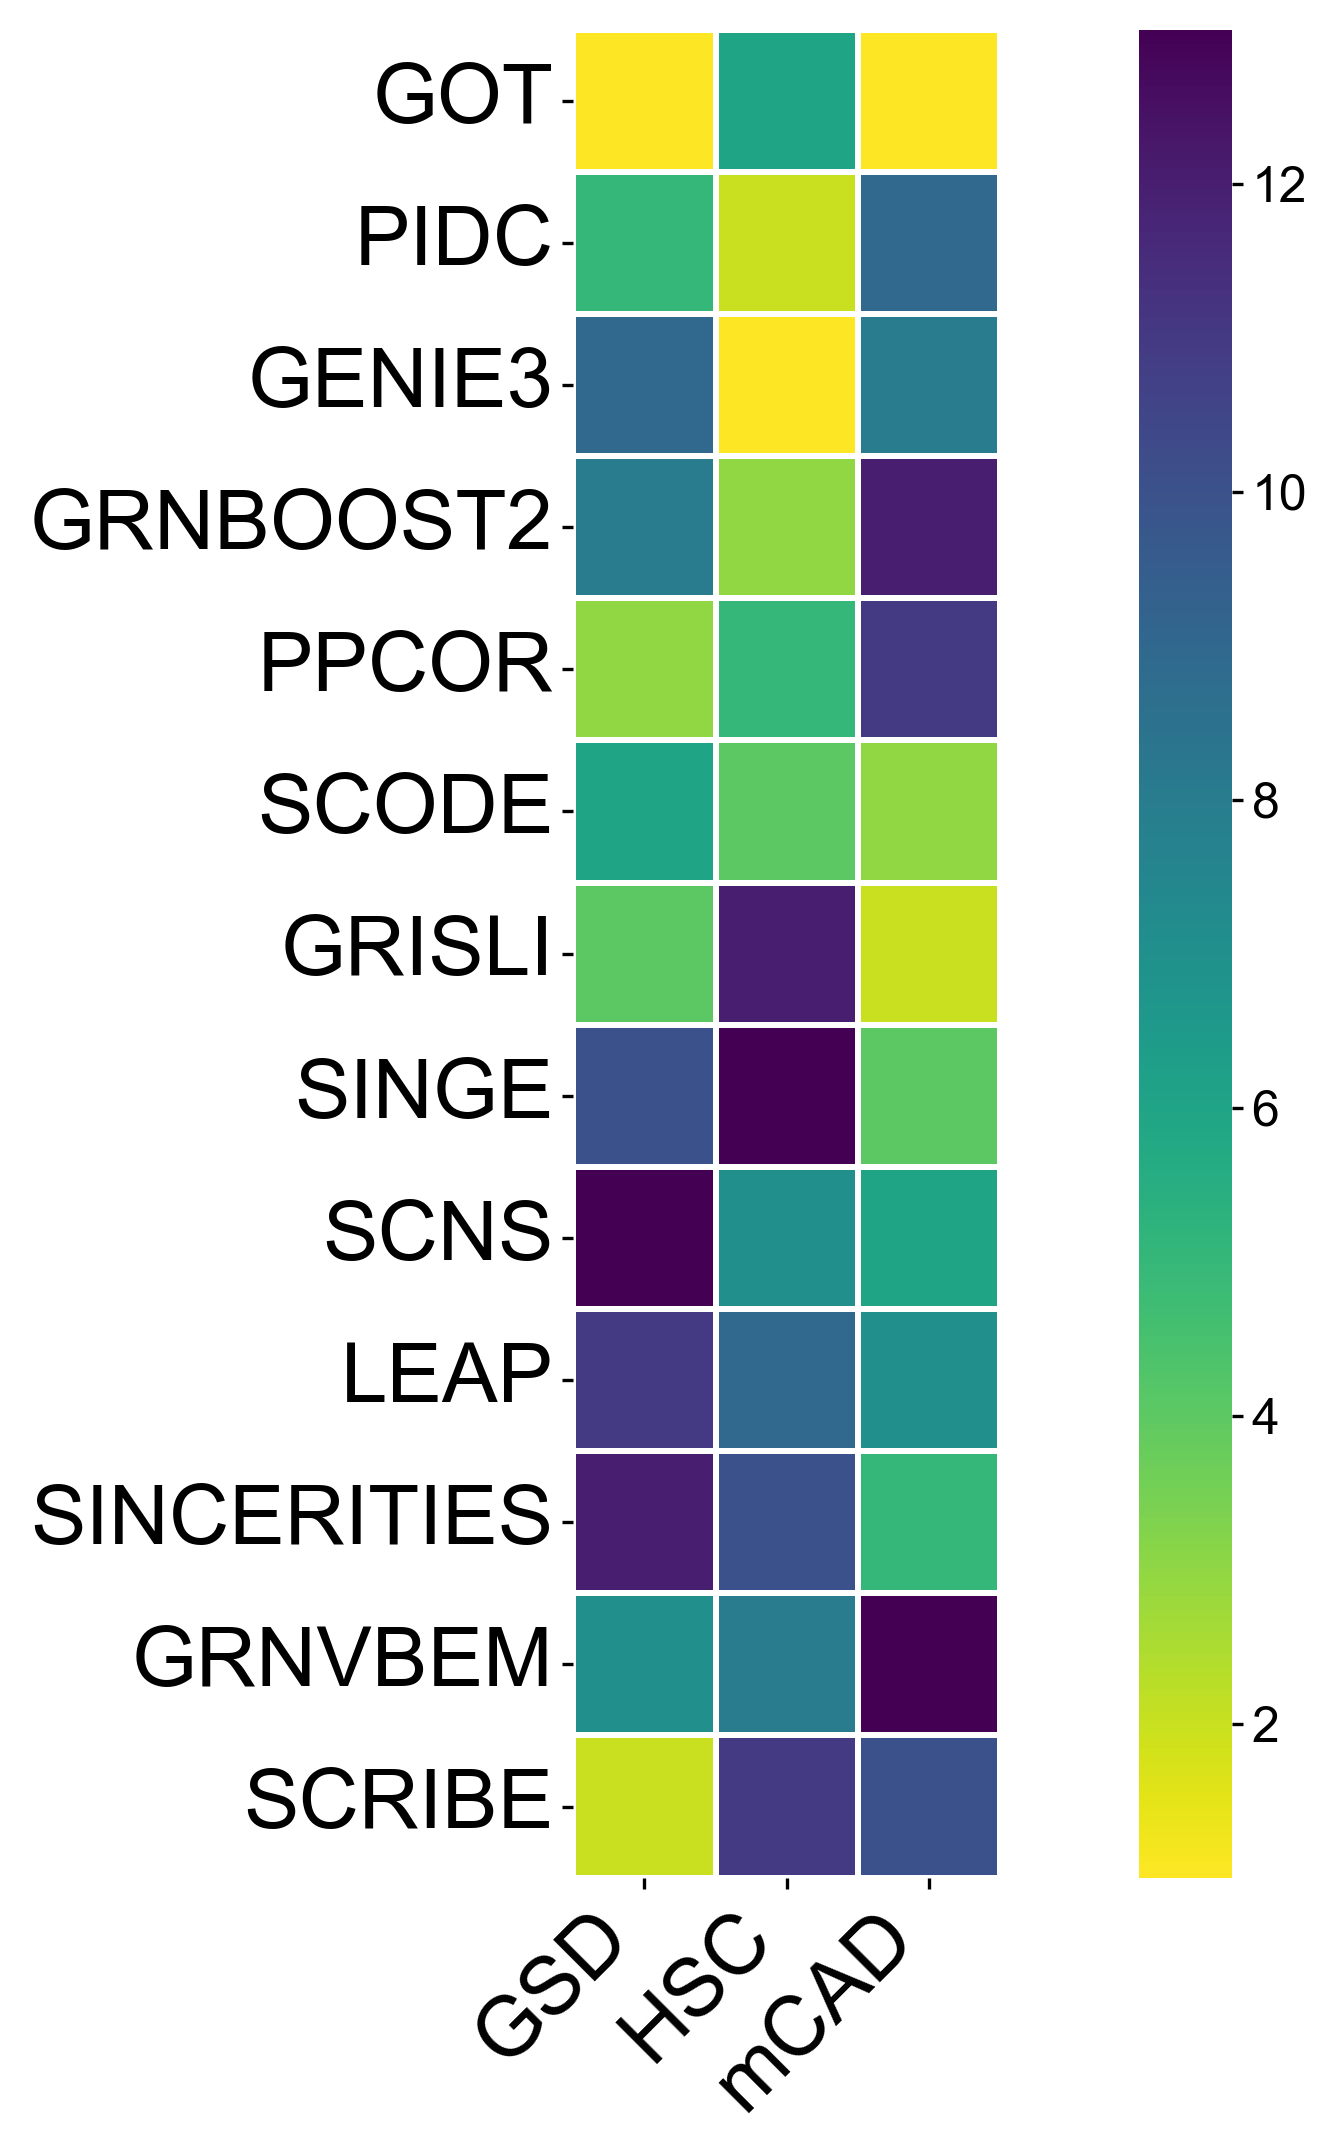

In [23]:
rank_df_curated = benchmark_results_curated.rank(ascending=False, axis=0, method='min')  # method='min'：并列取最低排名数

fig, ax = plt.subplots(1,1,figsize=(12, 8), dpi=300)
sns.heatmap(rank_df_curated, cmap="viridis_r", square=True, linecolor='white', linewidths=1, ax=ax, annot=False,annot_kws={'fontsize':14}, fmt=".2f")
plt.xlabel("", fontsize=14) 
plt.ylabel("", fontsize=14) 

plt.xticks(rotation=45, ha='right', fontsize=20, color='black') 
plt.yticks(fontsize=20, color='black')
plt.show()

In [24]:
benchmark_results = pd.concat([benchmark_results_syn, benchmark_results_curated], axis=1)
rank_df = pd.concat([rank_df_syn, rank_df_curated], axis=1)

In [25]:
sorted_idx = rank_df.sum(axis=1).sort_values().index

In [26]:
rank_df.sum(axis=1).sort_values()

GOT            23.0
SINCERITIES    43.0
PIDC           46.0
PPCOR          50.0
SCRIBE         55.0
GRNBOOST2      65.0
GENIE3         68.0
SINGE          70.0
LEAP           73.0
SCODE          73.0
GRISLI         76.0
GRNVBEM        84.0
SCNS           93.0
dtype: float64

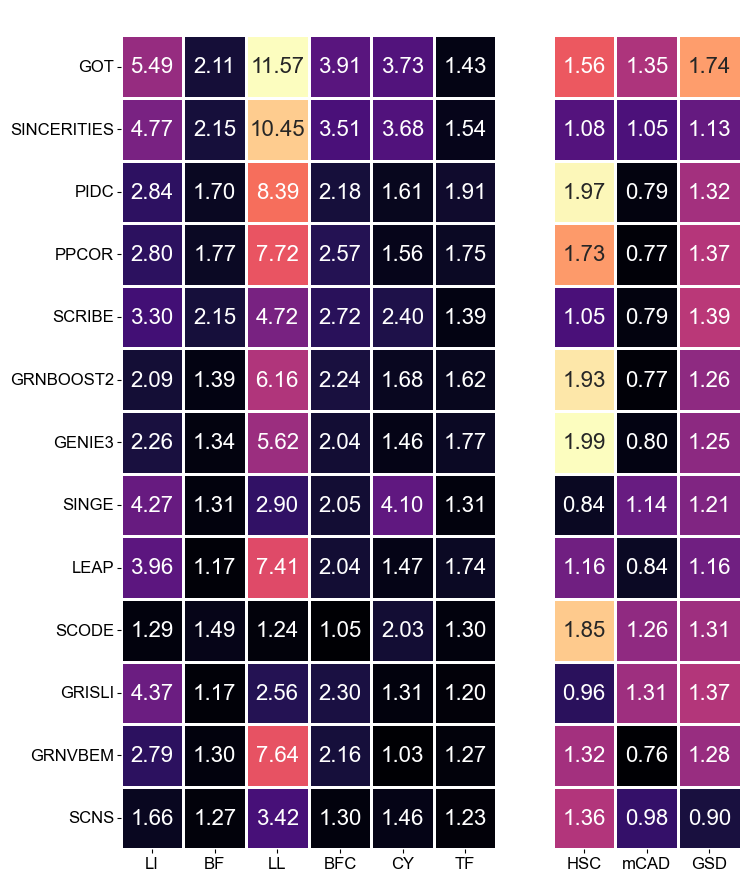

In [27]:

fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 12), gridspec_kw={'width_ratios': [6, 3]})


sns.heatmap(benchmark_results.loc[sorted_idx][['LI', 'BF', 'LL', 'BFC', 'CY', 'TF']], square=True,  linecolor='white', annot=True, fmt=".2f", linewidths=1, cmap="magma", ax=ax1, cbar=False, )
ax1.set_title(' ')


sns.heatmap(benchmark_results.loc[sorted_idx][['HSC', 'mCAD', 'GSD']], square=True,  linecolor='white', linewidths=1, annot=True, fmt=".2f", cmap="magma", ax=ax2, cbar=False, yticklabels=False)

ax2.set_title(' ')

plt.show()

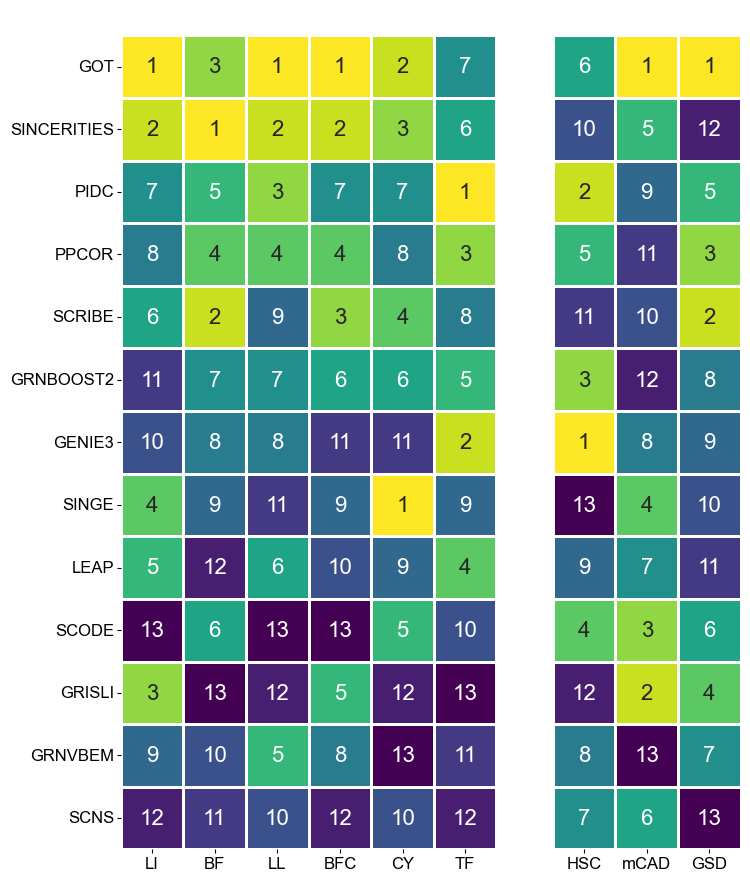

In [28]:
fig, (ax1, ax2) = plt.subplots(ncols=2, nrows=1, figsize=(8, 12), gridspec_kw={'width_ratios': [6, 3]})


sns.heatmap(rank_df.loc[sorted_idx][['LI', 'BF', 'LL', 'BFC', 'CY', 'TF']], square=True,  linecolor='white', annot=True,  linewidths=1, cmap="viridis_r", ax=ax1, cbar=False, )
ax1.set_title(' ')


sns.heatmap(rank_df.loc[sorted_idx][['HSC', 'mCAD', 'GSD']], square=True,  linecolor='white', linewidths=1, annot=True, cmap="viridis_r", ax=ax2, cbar=False, yticklabels=False)

ax2.set_title(' ')

plt.show()

